In [1]:
import sys
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings


from src.utils.data_utils import (
    test_missing_bias,
    analyze_missing_patterns,
    get_missing_data_summary,
    missing_by_dataset,
    missing_by_outcome,
    find_medically_impossible_values,
    handle_impossible_zeros,
    impute_missing_values,
)
from src.utils.notebook_setup import setup_notebook_environment

# Quick setup
dbs, logger = await setup_notebook_environment()

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Now ready to work
logger.info("Starting data preprocessing...")

# Checking Bronze Layer
bronze_data = await dbs.get_bronze_data()
bronze_data_df = pd.DataFrame(bronze_data)
logger.info(bronze_data_df.head())

2025-07-24 17:16:58,993 - api.services.database_service - INFO - Connected to MongoDB database: healthcare
2025-07-24 17:16:59,107 - src.utils.notebook_setup - INFO - Database connected: True
2025-07-24 17:16:59,109 - src.utils.notebook_setup - INFO - Database collections: ['heart_disease_gold', 'heart_disease_silver', 'heart_disease_bronze']
2025-07-24 17:16:59,111 - src.utils.notebook_setup - INFO - Database collections count: 3
2025-07-24 17:16:59,114 - src.utils.notebook_setup - INFO - Starting data preprocessing...
2025-07-24 17:16:59,702 - src.utils.notebook_setup - INFO -                         _id  id  age     sex    dataset               cp  \
0  68811cb7d1fe98210f462c54   1   63    Male  Cleveland   typical angina   
1  68811cb7d1fe98210f462c55   2   67    Male  Cleveland     asymptomatic   
2  68811cb7d1fe98210f462c56   3   67    Male  Cleveland     asymptomatic   
3  68811cb7d1fe98210f462c57   4   37    Male  Cleveland      non-anginal   
4  68811cb7d1fe98210f462c58   5   

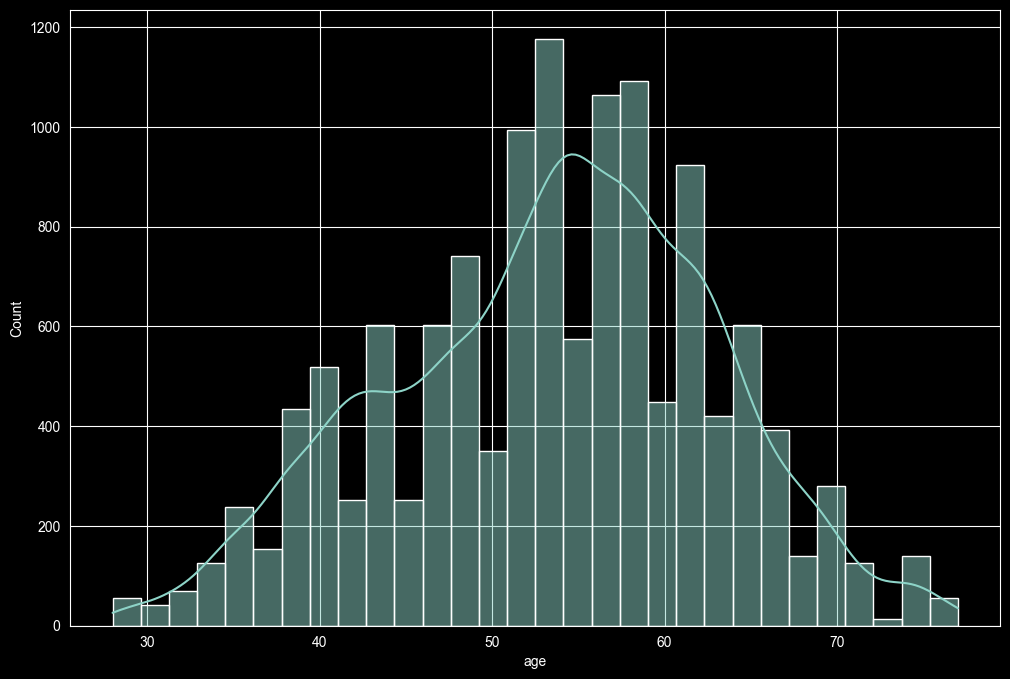

Mean: 53.51
Median: 54.00
Mode: 54.00


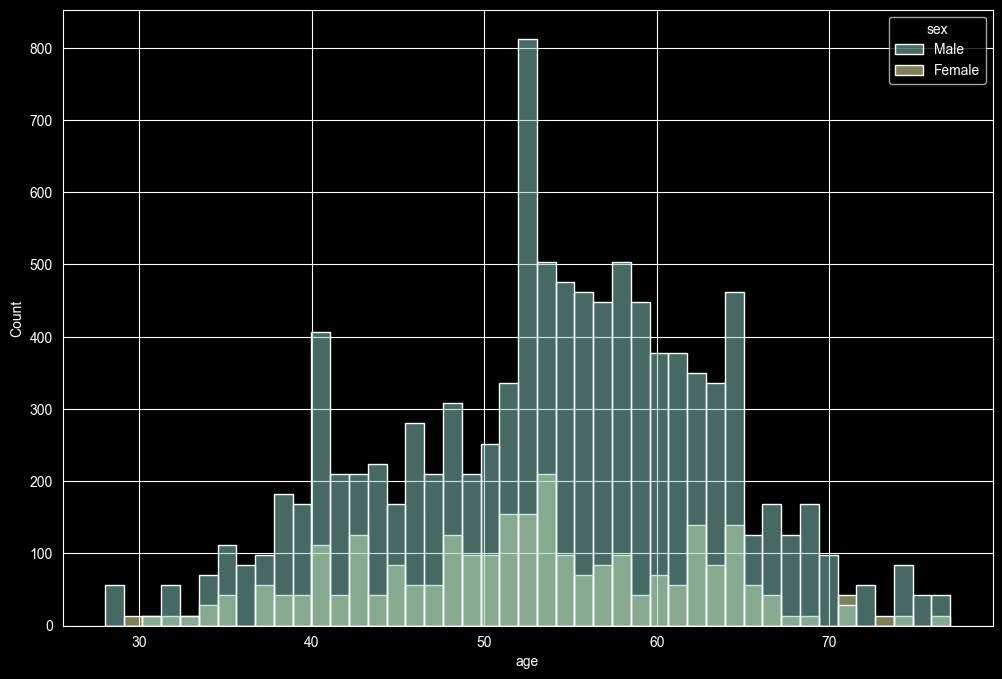

sex
Male      10164
Female     2716
Name: count, dtype: int64

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('dark_background')

# Histogram to see the distribution of age column
sns.histplot(bronze_data_df['age'], kde=True, bins=30)
plt.show()

print(f"Mean: {bronze_data_df['age'].mean():.2f}")
print(f"Median: {bronze_data_df['age'].median():.2f}")
print(f"Mode: {bronze_data_df['age'].mode()[0]:.2f}")


warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('dark_background')

# Histogram of the 'age' column colored by 'sex'
sns.histplot(data=bronze_data_df, x='age', hue='sex')
plt.show()

bronze_data_df['sex'].value_counts()

In [3]:
# Identify Duplicates
bronze_data_df.duplicated().sum()

if bronze_data_df.duplicated().sum() > 0:
    bronze_data_df = bronze_data_df.drop_duplicates()
    logger.info("Dropped duplicate rows")
else:
    logger.info("No duplicate rows found")

# checking data info
bronze_data_df.info()
logger.info(bronze_data_df.info())

# DROP COLUMNS
bronze_data_df = bronze_data_df.drop(columns=['_id', "id"])

# show dataframe
bronze_data_df.head()

2025-07-24 17:17:01,072 - src.utils.notebook_setup - INFO - No duplicate rows found
2025-07-24 17:17:01,103 - src.utils.notebook_setup - INFO - None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   _id       12880 non-null  object 
 1   id        12880 non-null  int64  
 2   age       12880 non-null  int64  
 3   sex       12880 non-null  object 
 4   dataset   12880 non-null  object 
 5   cp        12880 non-null  object 
 6   trestbps  12054 non-null  float64
 7   chol      12460 non-null  float64
 8   fbs       11620 non-null  object 
 9   restecg   12852 non-null  object 
 10  thalch    12110 non-null  float64
 11  exang     12110 non-null  object 
 12  oldpeak   12012 non-null  float64
 13  slope     8554 non-null   object 
 14  ca        4326 non-null   float64
 15  thal      6076 non-null   object 
 16  num       12880 non-null  int64  
dtypes: float64(5), int64(3), object(9)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12880 entries, 0 to 12879
Data columns

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
# Checing Categorical Columns
cat_col = bronze_data_df.select_dtypes(include=['object']).columns
num_col = bronze_data_df.select_dtypes(include=['int64', 'float64']).columns


# Check unique values in categorical columns
logger.info("Unique value COUNT in categorical columns")
logger.info(bronze_data_df[cat_col].nunique())

logger.info("Unique values in categorical columns")
logger.info(f"ca: {bronze_data_df['ca'].unique()[:bronze_data_df['ca'].nunique()]}")
logger.info(f"thal: {bronze_data_df['thal'].unique()[:bronze_data_df['thal'].nunique()]}")
logger.info(f"slope: {bronze_data_df['slope'].unique()[:bronze_data_df['slope'].nunique()]}")

# Check numerical columns
logger.info("Unique values COUNT in numerical columns")
logger.info(bronze_data_df[num_col].nunique())



2025-07-24 17:17:01,142 - src.utils.notebook_setup - INFO - Unique value COUNT in categorical columns
2025-07-24 17:17:01,158 - src.utils.notebook_setup - INFO - sex        2
dataset    4
cp         4
fbs        2
restecg    3
exang      2
slope      3
thal       3
dtype: int64
2025-07-24 17:17:01,160 - src.utils.notebook_setup - INFO - Unique values in categorical columns
2025-07-24 17:17:01,163 - src.utils.notebook_setup - INFO - ca: [0. 3. 2. 1.]
2025-07-24 17:17:01,167 - src.utils.notebook_setup - INFO - thal: ['fixed defect' 'normal' 'reversable defect']
2025-07-24 17:17:01,170 - src.utils.notebook_setup - INFO - slope: ['downsloping' 'flat' 'upsloping']
2025-07-24 17:17:01,172 - src.utils.notebook_setup - INFO - Unique values COUNT in numerical columns
2025-07-24 17:17:01,177 - src.utils.notebook_setup - INFO - age          50
trestbps     61
chol        217
thalch      119
oldpeak      53
ca            4
num           5
dtype: int64


In [5]:
missing_df = get_missing_data_summary(bronze_data_df)

missing_df.head(20)

,Column,Missing Count,Missing %,Severity
2,fbs,"1,260",9.8%,Low
8,ca,"8,554",66.4%,High
6,oldpeak,868,6.7%,Low
0,trestbps,826,6.4%,Low
4,thalch,770,6.0%,Low
5,exang,770,6.0%,Low
9,thal,"6,804",52.8%,High
7,slope,"4,326",33.6%,High
1,chol,420,3.3%,Low
3,restecg,28,0.2%,Low


In [6]:
# Running Tests Missing Data to Determine MNAR or MAR Missingness

# TRUE = Missing pattern correlates with heart disease outcome, most likely missing because of patient condition (sicker patients get more tests)

missing_bias_df = pd.DataFrame(columns=['Column', 'MNAR from Chi-square test'])
for col in bronze_data_df.columns:
    missing_bias_df.loc[len(missing_bias_df)] = [col, test_missing_bias(bronze_data_df, col, 'num')]

logger.info("Missing bias:")
missing_bias_df.head(20)

2025-07-24 17:17:01,413 - src.utils.notebook_setup - INFO - Missing bias:


,Column,MNAR from Chi-square test
0,age,False
1,sex,False
2,dataset,False
3,cp,False
4,trestbps,True
5,chol,True
6,fbs,True
7,restecg,True
8,thalch,True
9,exang,True


In [7]:
# Running Tests Missing Data to Determine MNAR or MAR Missing by Dataset

# TRUE = Different studies have different missing patterns, Different hospitals/studies had different protocols
missing_by_dataset_df = pd.DataFrame(columns=['Column', 'MNAR FROM DATASET ORIGIN'])
for col in bronze_data_df.columns:
    missing_by_dataset_df.loc[len(missing_by_dataset_df)] = [col, missing_by_dataset(bronze_data_df, col)]

logger.info("Missing by dataset:")
missing_by_dataset_df.head(20)

2025-07-24 17:17:01,550 - src.utils.notebook_setup - INFO - Missing by dataset:


,Column,MNAR FROM DATASET ORIGIN
0,age,False
1,sex,False
2,dataset,False
3,cp,False
4,trestbps,True
5,chol,False
6,fbs,True
7,restecg,False
8,thalch,True
9,exang,True


In [8]:
# Check missingness by outcome

missing_by_outcome_df = pd.DataFrame(columns=['Column', 'MNAR FROM OUTCOME'])
for col in bronze_data_df.columns:
    missing_by_outcome_df.loc[len(missing_by_outcome_df)] = [col, missing_by_outcome(bronze_data_df, col)]

logger.info("Missing by outcome:")
missing_by_outcome_df.head(20)


2025-07-24 17:17:01,668 - src.utils.notebook_setup - INFO - Missing by outcome:


,Column,MNAR FROM OUTCOME
0,age,False
1,sex,False
2,dataset,False
3,cp,False
4,trestbps,False
5,chol,False
6,fbs,True
7,restecg,False
8,thalch,False
9,exang,False


In [9]:
# Create binary target as required
bronze_data_df['target'] = (bronze_data_df['num'] > 0).astype(int)
# 0 = no heart disease, 1 = any heart disease

# Drop original multi-class target  
bronze_data_df = bronze_data_df.drop(columns=['num'])
bronze_data_df.head(20)


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,1
7,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,1
9,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


In [10]:
"""
Judging from the MNAR tests and the missing patterns, we can see that ca and thal values should be dropped
 - Medical knowledge confirms that 'ca' being fluoroscopy is an expensive and invasive test only order for most likely high risk paitents
 - Medical knowledge confirms that 'thal' being a stress test is only conducted when doctors suspect heart problems
 - TRUE across all tests indicated that Systematic, non-random missingness
 - 66.4% and 52.8% missing = Too much missing data
 - Missingness predicts outcome, so we should drop these columns

 Imputing with mean or mode would introdue bias!
"""

# Drop ca and thal columns
logger.info("Dropping ca and thal columns!")
if 'ca' in bronze_data_df.columns and 'thal' in bronze_data_df.columns:
    bronze_data_df = bronze_data_df.drop(columns=['ca', 'thal'])

logger.info(bronze_data_df.shape)
bronze_data_df.head()

2025-07-24 17:17:01,726 - src.utils.notebook_setup - INFO - Dropping ca and thal columns!
2025-07-24 17:17:01,730 - src.utils.notebook_setup - INFO - (12880, 13)


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0


In [11]:
"""
Slope is the slope of the peak exercise ST segment. It refers to the excercise stress test and when its administered it can be a valuable test
Now for the slope column ... there was about 33% missing data meaning that 66% of the data was complete. 

Stress test can be a valuable test, but it is not always administered. But even when its not administered, it can be an indicator that it was Not needed

So Since 
"""

# Create a new column for missing slope values
bronze_data_df['slope'] = bronze_data_df['slope'].fillna('not_tested')
logger.info(bronze_data_df.shape)
bronze_data_df.head()


# Find missing values again
missing_values = get_missing_data_summary(bronze_data_df)
logger.info("Missing values after handling slope missing values")
missing_values.head(20)

2025-07-24 17:17:01,848 - src.utils.notebook_setup - INFO - (12880, 13)
2025-07-24 17:17:01,875 - src.utils.notebook_setup - INFO - Missing values after handling slope missing values


,Column,Missing Count,Missing %,Severity
2,fbs,"1,260",9.8%,Low
6,oldpeak,868,6.7%,Low
0,trestbps,826,6.4%,Low
4,thalch,770,6.0%,Low
5,exang,770,6.0%,Low
1,chol,420,3.3%,Low
3,restecg,28,0.2%,Low


In [ ]:
# Find medically impossible values
cleaned_df = handle_impossible_zeros(bronze_data_df)

# 2. Impute all missing values (including new NaNs from zeros)
imputed_df = impute_missing_values(cleaned_df)

# 3. Verify no missing values remain : summing the null counts across all columns
assert imputed_df.isnull().sum().sum() == 0, "Still have missing values!"

# impossible_values = find_medically_impossible_values(imputed_df)

# impossible_values_df = pd.DataFrame(impossible_values)
# impossible_values_df.head(2)
# logger.info(impossible_values_df.shape)


2025-07-24 17:17:01,900 - src.utils.data_utils - INFO - chol: Replaced 2408 impossible zeros with NaN
2025-07-24 17:17:01,902 - src.utils.data_utils - INFO - trestbps: Replaced 14 impossible zeros with NaN
2025-07-24 17:17:01,904 - src.utils.data_utils - INFO - thalch: Replaced 0 impossible zeros with NaN
2025-07-24 17:17:01,907 - src.utils.data_utils - INFO - age: Replaced 0 impossible zeros with NaN
2025-07-24 17:17:01,913 - src.utils.data_utils - INFO - chol: Imputed 2828 missing values with median 239.5
2025-07-24 17:17:01,917 - src.utils.data_utils - INFO - trestbps: Imputed 840 missing values with median 130.0
2025-07-24 17:17:01,920 - src.utils.data_utils - INFO - thalch: Imputed 770 missing values with median 140.0
2025-07-24 17:17:01,922 - src.utils.data_utils - INFO - oldpeak: Imputed 868 missing values with median 0.5
2025-07-24 17:17:01,927 - src.utils.data_utils - INFO - fbs: Imputed 1260 missing values with mode 'False'
2025-07-24 17:17:01,933 - src.utils.data_utils - INF

In [13]:

# Final Step: Save cleaned data to Silver layer

# Verify final data quality
logger.info("=" * 60)
logger.info("FINAL SILVER LAYER DATA SUMMARY")
logger.info("=" * 60)

logger.info(f"Final dataset shape: {imputed_df.shape}")
logger.info(f"Missing values remaining: {imputed_df.isnull().sum().sum()}")
logger.info(f"Target variable distribution:\n{imputed_df['target'].value_counts()}")

# Show final columns
logger.info(f"Final columns: {list(imputed_df.columns)}")

# Save to Silver collection in MongoDB
logger.info("Saving cleaned data to Silver layer...")

# Convert DataFrame to records for MongoDB
silver_data = imputed_df.to_dict('records')

# Insert into Silver collection
success = await dbs.insert_silver_data(silver_data)

if success:
    logger.info(f"Successfully saved {len(silver_data)} records to Silver layer")
    
    # Verify the save
    silver_count = await dbs.get_collection_count('silver')
    logger.info(f"Silver collection now contains: {silver_count} documents")
    
    # Show sample of Silver data
    sample_silver = await dbs.get_sample_records('silver', count=3)
    logger.info("Sample Silver layer records:")
    for i, record in enumerate(sample_silver):
        logger.info(f"Record {i+1}: {record}")
        
else:
    logger.error("Failed to save data to Silver layer")

logger.info("Data preprocessing complete! Ready for feature engineering.")

2025-07-24 17:17:01,959 - src.utils.notebook_setup - INFO - ============================================================
2025-07-24 17:17:01,961 - src.utils.notebook_setup - INFO - FINAL SILVER LAYER DATA SUMMARY
2025-07-24 17:17:01,962 - src.utils.notebook_setup - INFO - ============================================================
2025-07-24 17:17:01,964 - src.utils.notebook_setup - INFO - Final dataset shape: (12880, 13)
2025-07-24 17:17:01,973 - src.utils.notebook_setup - INFO - Missing values remaining: 0
2025-07-24 17:17:01,976 - src.utils.notebook_setup - INFO - Target variable distribution:
target
1    7126
0    5754
Name: count, dtype: int64
2025-07-24 17:17:01,977 - src.utils.notebook_setup - INFO - Final columns: ['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'target']
2025-07-24 17:17:01,978 - src.utils.notebook_setup - INFO - Saving cleaned data to Silver layer...
2025-07-24 17:17:09,624 - api.services.database_s